<a href="https://colab.research.google.com/github/dandiario/ds_spring_2020/blob/master/March_Madness_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Final Project - March Madness Prediction

## David Andiario and Evan Okin

## May 2020

## Overview

The following report is broken up into several sections:

Section 1: Defining the Business Problem

Section 2: Exploring the Data

Section 3: Machine Learning and Prediction (Without Rating)

Section 4: Machine Learning and Prediction (With Rating)

Section 5: Deploying the Model

Section 6: Conclusion

## Section 1: Defining the Business Problem

The University of Michigan wants to understand what strategies are needed to win in the NCAA March Madness Tournament. We were hired as analysts because they believe if they can find an important strategy to win, it would bring in more fans, higher profits for the school, and increase brand recognition for the University of Michigan, which in turn will lead to a stronger applicant pool (Go Blue).

## Approach

We are tackling a classification problem (can we predict if a given team will win in the NCAA tournament, based on regular season results). We have a vast amount of box score data (eg points, rebounds, assists, steals) for Division 1 games dating back to 1984. We will use box score data as "features." We will use an ID for each school, randomized so that we have balance (a lower ID team is equally likely to beat a higher ID team). The target variable will be whether or not the lower ID ranked team won the game, given the features. Thus we will have a balanced dataset and will (at least initially) start by analyzing accuracy. We will then expand our approach to see how much money our accuracy would translate to, within an expected value framework.

## Data Source

We utilized a trove of information from the following source, https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/data.

## Section 2: Exploring the Data

In this section we explore the data that we have available. We describe the variables that we have at our disposal and produce visualizations using the data.

Import necessary libraries.

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Load in the dataframe.

In [186]:
df_tournament = pd.read_csv('MNCAATourneyDetailedResults.csv')

Preview the dataframe.

In [187]:
df_tournament.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18


And now the smaller version.

In [188]:
df_tournament_compact = pd.read_csv('MNCAATourneyCompactResults.csv')

In [189]:
%%capture
df_tournament_compact.head(3)

We will want to analyze as many features as possible for our Machine Learning model. Thus, we will do the majority of our work on the detailed dataset. We will load in info on historical games to help feed our training model.

In [190]:
df_master = pd.read_csv('MRegularSeasonDetailedResults.csv')

We also have player specific information.

In [191]:
df_players = pd.read_csv('MPlayers.csv')

In [192]:
%%capture
df_players.head(3)

Let's explore our master dataset.

In [193]:
print('Number of rows of data: ', df_tournament.shape[0])
print('Number of columns of data: ', df_tournament.shape[1])

Number of rows of data:  1115
Number of columns of data:  34


In [194]:
print('List of Columns with data: ' ,list(df_tournament.columns))

List of Columns with data:  ['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']


Text(0, 0.5, 'Number of Games')

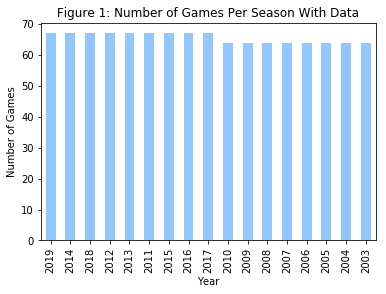

In [195]:
df_tournament['Season'].value_counts().plot(kind='bar')
plt.title('Figure 1: Number of Games Per Season With Data')
plt.xlabel('Year')
plt.ylabel('Number of Games')

In [196]:
df_master.head(3);

In [197]:
print('Number of rows of data: ', df_master.shape[0])
print('Number of columns of data: ', df_master.shape[1])
df_master.shape

Number of rows of data:  87504
Number of columns of data:  34


(87504, 34)

In [198]:
print('Confirm that our columns of data match : ' ,len(df_master.columns)==len(df_tournament.columns))

Confirm that our columns of data match :  True


In [199]:
df_master.columns==df_tournament.columns;

In [200]:
for i in df_master.columns:
    if df_master[i].isna().sum()>0:
        print(i,df_master[i].isna().sum())

Nothing printed, because the data is very clean, nothing null in this dataset.

In [201]:
print('List of Columns with data: ' ,list(df_master.columns))

List of Columns with data:  ['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']


Season - this is the year of the associated entry in MSeasons.csv (the year in which the final tournament occurs). For example, during the 2016 season, there were regular season games played between November 2015 and March 2016, and all of those games will show up with a Season of 2016.

Text(0, 0.5, 'Number of Games')

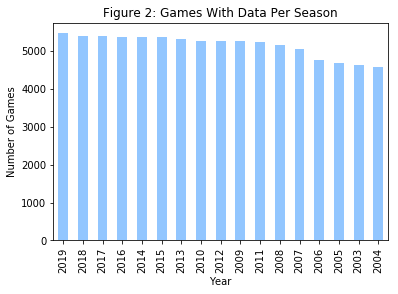

In [202]:
df_master['Season'].value_counts().plot(kind='bar')
plt.title('Figure 2: Games With Data Per Season')
plt.xlabel('Year')
plt.ylabel('Number of Games')

We have the following variables for our machine learning models, which we have separately explored but do not show here.

DayNum - this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "DayZero" date in the "MSeasons.csv" file. For example, the first game in the file was DayNum=20. Combined with the fact from the "MSeasons.csv" file that day zero was 10/29/1984 that year, this means the first game was played 20 days later, or 11/18/1984. There are no teams that ever played more than one game on a given date, so you can use this fact if you need a unique key (combining Season and DayNum and WTeamID). In order to accomplish this uniqueness, we had to adjust one game's date. In March 2008, the SEC postseason tournament had to reschedule one game (Georgia-Kentucky) to a subsequent day because of a tornado, so Georgia had to actually play two games on the same day. In order to enforce this uniqueness, we moved the game date for the Georgia-Kentucky game back to its original scheduled date.

WTeamID - this identifies the id number of the team that won the game, as listed in the "MTeams.csv" file. No matter whether the game was won by the home team or visiting team, or if it was a neutral-site game, the "WTeamID" always identifies the winning team.

WScore - this identifies the number of points scored by the winning team.

LTeamID - this identifies the id number of the team that lost the game.

LScore - this identifies the number of points scored by the losing team. Thus you can be confident that WScore will be greater than LScore for all games listed.

WLoc - this identifies the "location" of the winning team. If the winning team was the home team, this value will be "H". If the winning team was the visiting team, this value will be "A". If it was played on a neutral court, then this value will be "N". Sometimes it is unclear whether the site should be considered neutral, since it is near one team's home court, or even on their court during a tournament, but for this determination we have simply used the Kenneth Massey data in its current state, where the "@" sign is either listed with the winning team, the losing team, or neither team. If you would like to investigate this factor more closely, we invite you to explore Data Section 3, which provides the city that each game was played in, irrespective of whether it was considered to be a neutral site.

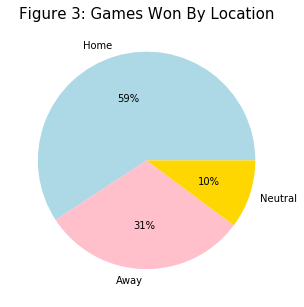

['Home', 'Away', 'Neutral']

In [203]:
labels=['Home','Away','Neutral']
sizes=df_master['WLoc'].value_counts().values
colors=['lightblue','pink','gold']
explode=[0,0,0]
plt.style.use('seaborn-pastel')
plt.figure(figsize=(5,5))
plt.pie(sizes,explode=explode,labels=labels,colors=colors,autopct= '%1.0f%%')
plt.title('Figure 3: Games Won By Location',fontsize=15)
plt.show()
labels

NumOT - this indicates the number of overtime periods in the game, an integer 0 or higher.

In [204]:
print('Distribution of Games and Number of Overtimes')
round(df_master['NumOT'].value_counts(normalize=True),5)

Distribution of Games and Number of Overtimes


0   0.94%
1   0.05%
2   0.01%
3   0.00%
4   0.00%
5   0.00%
6   0.00%
Name: NumOT, dtype: float64

WFGM - field goals made (by the winning team)

WFGA - field goals attempted (by the winning team)

WFGM3 - three pointers made (by the winning team)

WFGA3 - three pointers attempted (by the winning team)

WFTM - free throws made (by the winning team)

WFTA - free throws attempted (by the winning team)

WOR - offensive rebounds (pulled by the winning team)

WDR - defensive rebounds (pulled by the winning team)

WAst - assists (by the winning team)

WTO - turnovers committed (by the winning team)

WStl - steals (accomplished by the winning team)

WBlk - blocks (accomplished by the winning team)

WPF - personal fouls committed (by the winning team)

LFGM - field goals made (by the losing team)

LFGA - field goals attempted (by the losing team)

LFGM3 - three pointers made (by the losing team)

LFGA3 - three pointers attempted (by the losing team)

LFTM - free throws made (by the losing team)

LFTA - free throws attempted (by the losing team)

LOR - offensive rebounds (pulled by the losing team)

LDR - defensive rebounds (pulled by the losing team)

LAst - assists (by the losing team)

LTO - turnovers committed (by the losing team)

LStl - steals (accomplished by the losing team)

LBlk - blocks (accomplished by the losing team)

LPF - personal fouls committed (by the losing team)

Load data from rankings to merge into the master dataset

In [205]:
rankings = pd.read_csv('MMasseyOrdinals.csv')

In [206]:
rankings.head();

Regular season statistics with rankings

In [207]:
stats_rankings = pd.read_csv('MRegDet_Rankings.csv')

# Section 3: Machine Learning and Prediction (Without Rating)

In this section, we run several machine learning algorithms to predict whether or not a team will win in a head-to-head matchup. Our objective is to take box season statistics for the regular season, and use those statistics to predict whether or not a team will win against an opponent, based on the differential between the two teams' box statistics. We spend some time setting up our variables properly, and then explore classification predictions under various algorithms.

In [208]:
df_master.head(3);

Let's try to help the machine by creating columns which could be more predictive.

We analyze differences in box score statistics from the winning and losing team, just to explore for now (not for predictive power).

In [209]:
df_master['DiffAst']=df_master['WAst']-df_master['LAst']
df_master['DiffReb']=df_master['WOR']+df_master['WDR']-df_master['LOR']-df_master['LDR']
df_master['DiffStl']=df_master['WStl']-df_master['LStl']
df_master['DiffBlk']=df_master['WBlk']-df_master['LBlk']

In [210]:
df_analysis=df_master[['DiffAst','DiffReb','DiffStl','DiffBlk']]

In [211]:
df_analysis.head(3);

In [212]:
df_analysis.describe()

,DiffAst,DiffReb,DiffStl,DiffBlk
count,87504.00%,87504.00%,87504.00%,87504.00%
mean,3.30%,3.83%,1.00%,0.96%
std,5.19%,8.47%,3.92%,3.15%
min,-19.00%,-31.00%,-18.00%,-16.00%
25%,0.00%,-2.00%,-2.00%,-1.00%
50%,3.00%,4.00%,1.00%,1.00%
75%,7.00%,9.00%,4.00%,3.00%
max,31.00%,48.00%,23.00%,19.00%


As expected, we encounter a positive difference for Ast, Reb, Stl, Blk for winning team minus losing team.

We can use difference from regular season to predict who would in the tournament.

In [213]:
import numpy as np
df_master['LowerID']=np.where(df_master['WTeamID']>df_master['LTeamID'],df_master['LTeamID'],df_master['WTeamID'])

In [214]:
df_master.head(3);

In [215]:
df_master['LowerAst']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['DiffAst'],-df_master['DiffAst'])
df_master['LowerReb']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['DiffReb'],-df_master['DiffReb'])
df_master['LowerStl']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['DiffStl'],-df_master['DiffStl'])
df_master['LowerBlk']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['DiffBlk'],-df_master['DiffBlk'])

In [216]:
df_master['WinIndicator']=np.where(df_master['LowerID']==df_master['WTeamID'],1,0)

In [217]:
df_prediction=df_master[['LowerAst','LowerReb','LowerStl','LowerBlk','WinIndicator']]

In [218]:
x=df_prediction[['LowerAst','LowerReb','LowerStl','LowerBlk']]

In [219]:
y=df_prediction['WinIndicator']

In [220]:
x.head(3);

In [221]:
y.head(3);

In [223]:
df_master.loc[df_master['Season']==2018].groupby('LowerID').mean().head(3);

In [224]:
df_master['LowerFGM']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['WFGM'],df_master['LFGM'])
df_master['LowerFGA']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['WFGA'],df_master['LFGA'])
df_master['LowerFGPercentage']=df_master['LowerFGM']/df_master['LowerFGA']

df_master['LowerFGM3']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['WFGM3'],df_master['LFGM3'])
df_master['LowerFGA3']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['WFGA3'],df_master['LFGA3'])
df_master['LowerFGPercentage3']=df_master['LowerFGM']/df_master['LowerFGA']

df_master['LowerFTM']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['WFTM'],df_master['LFTM'])
df_master['LowerFTA']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['WFTA'],df_master['LFTA'])
df_master['LowerFTPercentage']=df_master['LowerFTM']/df_master['LowerFTA']

df_master['LowerOR']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['WOR'],df_master['LOR'])

df_master['LowerDR']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['WDR'],df_master['LDR'])

df_master['LowerAst']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['WAst'],df_master['LAst'])

df_master['LowerTO']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['WTO'],df_master['LTO'])

df_master['LowerStl']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['WStl'],df_master['LStl'])

df_master['LowerBlk']=np.where(df_master['LowerID']==df_master['WTeamID'],df_master['WBlk'],df_master['LBlk'])

In [225]:
print('Names of Columns Set Up For Machine Learning ' , list(df_master.columns))

Names of Columns Set Up For Machine Learning  ['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'DiffAst', 'DiffReb', 'DiffStl', 'DiffBlk', 'LowerID', 'LowerAst', 'LowerReb', 'LowerStl', 'LowerBlk', 'WinIndicator', 'LowerFGM', 'LowerFGA', 'LowerFGPercentage', 'LowerFGM3', 'LowerFGA3', 'LowerFGPercentage3', 'LowerFTM', 'LowerFTA', 'LowerFTPercentage', 'LowerOR', 'LowerDR', 'LowerTO']


In [226]:
df_stats=df_master.groupby(['LowerID','Season']).mean()[['LowerAst','LowerReb','LowerStl','LowerBlk',
                                                                   'LowerFGPercentage','LowerFGPercentage3',
                                                                   'LowerFTPercentage','LowerOR','LowerDR',
                                                                   'LowerTO']]

In [227]:
df_stats.head(3);

In [231]:
len(df_stats);

In [232]:
df_stats.to_excel('AllYearsStats.xlsx')

In [233]:
df_pred_time=df_tournament[['Season','WTeamID','LTeamID']]

In [234]:
df_pred_time.head(3);

In [235]:
df_pred_time['Lower']=np.where(df_pred_time['WTeamID']>df_pred_time['LTeamID'],df_pred_time['LTeamID'],df_pred_time['WTeamID'])

In [236]:
df_pred_time['LowerWin']=np.where(df_pred_time['WTeamID']==df_pred_time['Lower'],1,0)

In [237]:
df_pred_time.to_excel('IDs.xlsx')

In [238]:
df=pd.read_excel('IDs_Modified.xlsx',sheetname='Pull')

In [239]:
df.head(3); #all columns are differences between Lower Team and Higher Team by ID

In [240]:
df.dropna(inplace=True)

In [241]:
len(df); #Drop 13% of data, still have a lot so it's ok

Our question at hand is as follows, can we predict if the lower ID team will win in the NCAA Tourney based on our regular season stats?

We will use different algorithms and test based on accuracy, because we expect a balanced dataset (since ID # is roughly arbitrary). We also care about accuracy because we have balanced data. The feature vector, x, includes the differences in box score statistics between the team with the lower ID and the team with the higher ID. Meanwhile, the target value is whether or the lower ID team beat the higher ID team when the two teams faced off in the NCAA tournament.

In [242]:
#Feature Vector
x=df[['Dast','Dreb','DStl','DBlk','DFGPerc','DFGPerc3','DFTP','DTO']]

In [243]:
#Target Variable
y=df[['LowerWin']]

In [244]:
x.head(3);

Notice the "D" as the first character of every feature, because it's the difference between the lower team ID and the higher team ID.

In order to not over-fit our model, we split the data into a training test and a testing set. We split the data into 80% used for training the model and 20% used for holdout data to test the model.

In [245]:
from sklearn.model_selection import train_test_split

In [246]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42) 
#Set random state set for reproducibility, by default already shuffled

We run a Logistic Regression to classify our data.

In [247]:
from sklearn.linear_model import LogisticRegression
logmodel=LogisticRegression()
logmodel.fit(x_train,y_train);

We create predictions for the testing set.

In [248]:
predictions=logmodel.predict(x_test)

We run a classification report to observe precision, recall and accuracy for our predictions.

In [249]:
from sklearn.metrics import classification_report

In [250]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.62      0.67      0.65        98
           1       0.64      0.58      0.61        96

   micro avg       0.63      0.63      0.63       194
   macro avg       0.63      0.63      0.63       194
weighted avg       0.63      0.63      0.63       194



We run a confusion matrix to observe the proportion of true positives, true negatives, false positives and false negatives.

In [251]:
from sklearn.metrics import confusion_matrix

In [252]:
print(confusion_matrix(y_test,predictions))

[[66 32]
 [40 56]]


We display model accuracy for our Logistic Regression.

In [253]:
from sklearn.metrics import accuracy_score

In [254]:
logistic_accuracy_score=accuracy_score(y_test,predictions)

In [255]:
print('Logistic Accuracy: ',(format(logistic_accuracy_score,".2%")))

Logistic Accuracy:  62.89%


We run a Decision Tree for classification. We'll come back later to optimize the parameters.

In [256]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [257]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42) 
#Random state set for reproducibility

In [258]:
model=DecisionTreeClassifier(max_depth=10)

In [259]:
scores=cross_val_score(model,x_train,y_train,scoring="accuracy",cv=10)

In [260]:
print("Cross Validated Accuracy: %0.3f +/- %0.3f" % (scores.mean(),scores.std()))

Cross Validated Accuracy: 0.582 +/- 0.041


In [261]:
model=DecisionTreeClassifier(max_depth=10)
model.fit(x_train,y_train)
predictions=model.predict(x_test)

We display a confusion matrix, but this time using a heatmap visualization.

In [262]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Text(0.5, 1.0, 'Figure 4: Heatmap Confusion Matrix - Decision Tree Classification')

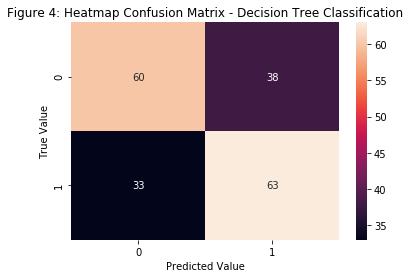

In [263]:
predictions=model.predict(x_test)
sns.heatmap(confusion_matrix(y_test,predictions),annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Figure 4: Heatmap Confusion Matrix - Decision Tree Classification')

We display model accuracy for Decision Trees.

In [264]:
from sklearn.metrics import accuracy_score

In [265]:
DT_accuracy_score=accuracy_score(y_test,predictions)

In [266]:
print('Decision Tree Accuracy: ',(format(DT_accuracy_score,".2%")))

Decision Tree Accuracy:  63.40%


We run a Random Forest for classification.

In [267]:
from sklearn.ensemble import RandomForestClassifier

In [268]:
model = RandomForestClassifier(n_estimators=200)

In [269]:
%%capture
scores=cross_val_score(model,x_train,y_train,scoring="accuracy",cv=10);

In [270]:
print("Cross Validated Accuracy: %0.3f +/- %0.3f" % (scores.mean(),scores.std()))

Cross Validated Accuracy: 0.593 +/- 0.052


In [271]:
%%capture
model.fit(x_train,y_train);

In [272]:
predictions=model.predict(x_test)

We display model accuracy for Random Forest.

In [273]:
from sklearn.metrics import accuracy_score

In [274]:
RF_accuracy_score=accuracy_score(y_test,predictions)

In [275]:
print('Random Forest Accuracy: ',(format(RF_accuracy_score,".2%")))

Random Forest Accuracy:  60.82%


We run a Grid Search to optimize hyper-parameters for our Random Forest (only a select, optimized set is shown below so as not to display a large amount of output).

In [276]:
from sklearn.model_selection import GridSearchCV

In [277]:
n_estimators=[int(x) for x in np.linspace(start=2000,stop=2000,num=1)]
max_depth=[int(x) for x in np.linspace(100,100,num=1)]
min_samples_leaf=[5]

In [278]:
param_grid={'n_estimators':n_estimators,
           'max_depth':max_depth,
           'min_samples_leaf':min_samples_leaf}
print(param_grid)

{'n_estimators': [2000], 'max_depth': [100], 'min_samples_leaf': [5]}


In [279]:
grid=GridSearchCV(RandomForestClassifier(),param_grid,verbose=5)

In [280]:
%%capture
grid.fit(x_train,y_train);

In [281]:
grid.best_params_;

In [282]:
grid.best_estimator_;

In [283]:
grid_predictions=grid.predict(x_test)

We display model accuracy for our optimized Random Forest.

In [284]:
from sklearn.metrics import accuracy_score

In [285]:
RF_accuracy_score=accuracy_score(y_test,grid_predictions)

In [286]:
print('Random Forest Accuracy (After Optimizing): ',(format(RF_accuracy_score,".2%")))

Random Forest Accuracy (After Optimizing):  62.89%


We run a Support Vector Machine for classification.

In [287]:
from sklearn.svm import SVC

In [288]:
model=SVC()

In [289]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42) 
#Random state set for reproducibility

In [290]:
model.fit(x_train,y_train);

In [291]:
predictions=model.predict(x_test)

We run a Grid Search to optimize hyper-parameters for an SVM, similar to how we optimized for our Random Forest.

In [292]:
from sklearn.model_selection import GridSearchCV

In [293]:
param_grid={'C':[10],'gamma':[.0001]}

In [294]:
grid=GridSearchCV(SVC(),param_grid,verbose=3)

In [295]:
%%capture
grid.fit(x_train,y_train);

In [296]:
grid.best_params_;

In [297]:
grid.best_estimator_;

In [298]:
grid_predictions=grid.predict(x_test)

We display model accuracy for the optimized SVM.

In [299]:
from sklearn.metrics import accuracy_score

In [300]:
SVM_accuracy_score=accuracy_score(y_test,grid_predictions)

In [301]:
print('SVM Accuracy (Optimized): ',(format(SVM_accuracy_score,".2%")))

SVM Accuracy (Optimized):  61.86%


Now that we've run several machine leraning algorithms to classify whether or not a team will win the NCAA Tournament based on the regular season box score statistics of the two teams, we can compare the accuracy results.

In [302]:
df=pd.DataFrame({"Machine Learning Algorithm":
                 ['Logistic Regression',
                 'Decision Trees','Random Forest',
                 'Support Vector Machine'],
                 "Accuracy":[logistic_accuracy_score,DT_accuracy_score,
                            RF_accuracy_score,SVM_accuracy_score]})

In [303]:
df.set_index('Machine Learning Algorithm',inplace=True)
pd.options.display.float_format = '{:.2f}%'.format

In [304]:
df['Accuracy']=round(df['Accuracy'],3)

In [305]:
df

,Accuracy
Machine Learning Algorithm,
Logistic Regression,0.63%
Decision Trees,0.63%
Random Forest,0.63%
Support Vector Machine,0.62%


## Section 4: Machine Learning and Prediction (With Rating)

We now take our machine learning a step further, by pulling in team ratings going into the tournament as another feature. We repeat the same type of analysis as above but with team ratings going into the NCAA game. 

In [306]:
df=pd.read_excel('IDs_Modified_w_Rankings.xlsx',sheet_name='Pull')

In [307]:
df.dropna(inplace=True)

In [308]:
df_2019 = df.loc[df['Year'] == 2019]
df_prior = df.loc[df['Year'] != 2019 ]

In [309]:
x_2019 = df_2019[['Dast','Dreb','DStl','DBlk','DFGPerc','DFGPerc3','DFTP','DTO',"ARG",	"BIH",	"COL",	"DOL",	"DUN",	"JNG",	"MAS",	"MOR",	"POM",	"RPI",	"RTH",	"SAG",	"SEL",	"WLK",	"WOB",	"WOL"]]
x_prior=df_prior[['Dast','Dreb','DStl','DBlk','DFGPerc','DFGPerc3','DFTP','DTO',"ARG",	"BIH",	"COL",	"DOL",	"DUN",	"JNG",	"MAS",	"MOR",	"POM",	"RPI",	"RTH",	"SAG",	"SEL",	"WLK",	"WOB",	"WOL"]]
x=df[['Dast','Dreb','DStl','DBlk','DFGPerc','DFGPerc3','DFTP','DTO',"ARG",	"BIH",	"COL",	"DOL",	"DUN",	"JNG",	"MAS",	"MOR",	"POM",	"RPI",	"RTH",	"SAG",	"SEL",	"WLK",	"WOB",	"WOL"]]

In [310]:
y_2019 = df_2019[['LowerWin']]
y_prior=df_prior[['LowerWin']]
y=df[['LowerWin']]

In [311]:
from sklearn.model_selection import train_test_split

In [312]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42) 

Logistic Regression:

In [313]:
def normalize(data):
  norm_rank = data[["ARG",	"BIH",	"COL",	"DOL",	"DUN",	"JNG",	"MAS",	"MOR",	"POM",	"RPI",		"RTH",	"SAG",	"SEL",	"WLK",	"WOB",	"WOL"]]/347
  Dast_norm = data[['Dast']]/data['Dast'].max()
  Dreb_norm = data[['Dreb']]/data['Dreb'].max()
  DStl_norm = data[['DStl']]/data['DStl'].max()
  DBlk_norm = data[['DBlk']]/data['DBlk'].max()
  DFGPerc_norm = data[['DFGPerc']]/data['DFGPerc'].max()
  DFGPerc3_norm = data[['DFGPerc3']]/data['DFGPerc3'].max()
  DFTP_norm = data[['DFTP']]/data['DFTP'].max()
  DTO_norm = data[['DTO']]/data['DTO'].max()
  normalized = pd.concat([norm_rank,Dast_norm,Dreb_norm,DStl_norm,DBlk_norm,DFGPerc_norm,DFGPerc3_norm,DFTP_norm,DTO_norm],axis=1)
  return normalized

In [314]:
# Normalize X-train
# divide rankings by number of teams
x_norm = normalize(x)
x_train_norm,x_test_norm,y_train_norm,y_test_norm=train_test_split(x_norm,y,test_size=0.2,random_state=42) 

In [315]:
from sklearn.linear_model import LogisticRegression
logmodel=LogisticRegression()
logmodel.fit(x_train_norm,y_train_norm);

In [316]:
from sklearn.metrics import roc_auc_score
predictions_logistic=logmodel.predict(x_test_norm)
probabilities_logistic = logmodel.predict_proba(x_test_norm)
auc_logistic = roc_auc_score(y_test, probabilities_logistic[:,1])

Run a classification report

In [317]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [318]:
print(classification_report(y_test_norm,predictions_logistic))
print("AUC = " + str(auc_logistic))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73        98
           1       0.73      0.70      0.71        96

   micro avg       0.72      0.72      0.72       194
   macro avg       0.72      0.72      0.72       194
weighted avg       0.72      0.72      0.72       194

AUC = 0.8030399659863946


Text(0, 0.5, 'True Positive Rate')

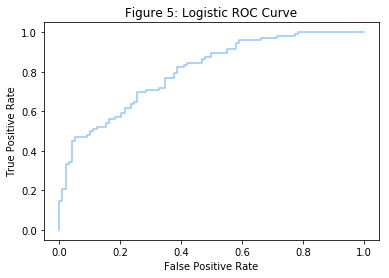

In [319]:
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, probabilities_logistic[:,1])
plt.plot(fpr_log, tpr_log)
plt.title('Figure 5: Logistic ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Run a confusion matrix

In [320]:
from sklearn.metrics import confusion_matrix

In [321]:
print(confusion_matrix(y_test,predictions_logistic))

[[73 25]
 [29 67]]


In [322]:
logistic_accuracy_score=accuracy_score(y_test,predictions_logistic)
print('Logistic Regression Accuracy (With Ratings): ',(format(logistic_accuracy_score,".2%")))

Logistic Regression Accuracy (With Ratings):  72.16%


Decision Tree:

In [323]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [324]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42) 
#Random state set for reproducibility

In [325]:
tree_model=DecisionTreeClassifier(max_depth=10)

In [326]:
scores=cross_val_score(tree_model,x_train,y_train,scoring="accuracy",cv=10)
print("Cross Validated Accuracy: %0.3f +/- %0.3f" % (scores.mean(),scores.std()))

Cross Validated Accuracy: 0.631 +/- 0.056


In [327]:
tree_model=DecisionTreeClassifier(max_depth=10)
tree_model.fit(x_train,y_train)
predictions=tree_model.predict(x_test)
probabilities_tree = tree_model.predict_proba(x_test)
auc_tree = roc_auc_score(y_test, probabilities_tree[:,1])

Text(0, 0.5, 'True Positive Rate')

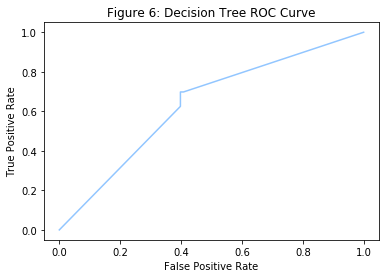

In [328]:
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, probabilities_tree[:,1])
plt.plot(fpr_tree, tpr_tree)
plt.title('Figure 6: Decision Tree ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [329]:
DT_accuracy_score=accuracy_score(y_test,predictions)

In [330]:
print('Decision Tree Accuracy (With Ratings): ',(format(DT_accuracy_score,".2%")))
print('Decision Tree AUC = ' + str(auc_tree))

Decision Tree Accuracy (With Ratings):  64.43%
Decision Tree AUC = 0.6339285714285715


Random Forest:

In [331]:
from sklearn.ensemble import RandomForestClassifier

In [332]:
forest_model = RandomForestClassifier(n_estimators=200)

In [333]:
scores=cross_val_score(forest_model,x_train,y_train,scoring="accuracy",cv=10);

In [156]:
print("Cross Validated Accuracy: %0.3f +/- %0.3f" % (scores.mean(),scores.std()))

Cross Validated Accuracy: 0.695 +/- 0.050


In [334]:
%%capture
forest_model.fit(x_train,y_train);

In [335]:
predictions_forest=forest_model.predict(x_test)
probabilities_forest = forest_model.predict_proba(x_test)
auc_forest = roc_auc_score(y_test, probabilities_forest[:,1])

In [336]:
print(classification_report(y_test,predictions_forest))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71        98
           1       0.70      0.72      0.71        96

   micro avg       0.71      0.71      0.71       194
   macro avg       0.71      0.71      0.71       194
weighted avg       0.71      0.71      0.71       194



Random Forest Accuracy (With Ratings):  71.13%
AUC = 0.8030399659863946


Text(0, 0.5, 'True Positive Rate')

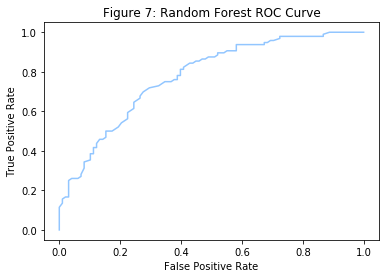

In [337]:
RF_accuracy_score=accuracy_score(y_test,predictions_forest)
print('Random Forest Accuracy (With Ratings): ',(format(RF_accuracy_score,".2%")))
print("AUC = " + str(auc_logistic))
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, probabilities_forest[:,1])
plt.plot(fpr_forest, tpr_forest)
plt.title('Figure 7: Random Forest ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Support Vector Machine:

In [338]:
from sklearn.svm import SVC

In [339]:
svc_model=SVC()

In [340]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42) 
#Random state set for reproducibility

In [343]:
svc_model.fit(x_train,y_train);

In [344]:
predictions_svc=svc_model.predict(x_test)
probabilities_svc = logmodel.predict_proba(x_test)
auc_svc = roc_auc_score(y_test, probabilities_svc[:,1])
print("AUC = " + str(auc_svc))

AUC = 0.7887967687074829


Text(0, 0.5, 'True Positive Rate')

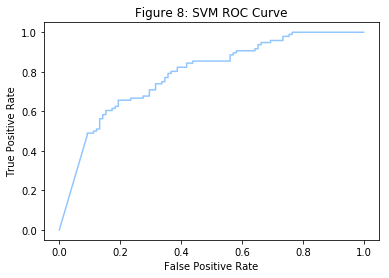

In [345]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, probabilities_svc[:,1])
plt.plot(fpr_svc, tpr_svc)
plt.title('Figure 8: SVM ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [346]:
from sklearn.model_selection import GridSearchCV

In [347]:
param_grid={'C':[1],'gamma':[.0001]}

In [348]:
grid=GridSearchCV(SVC(),param_grid,verbose=3)

In [349]:
%%capture
grid.fit(x_train,y_train);

In [350]:
grid.best_params_;

In [351]:
grid.best_estimator_;

In [352]:
grid_predictions=grid.predict(x_test)

In [353]:
SVM_accuracy_score=accuracy_score(y_test,grid_predictions)

In [354]:
print('SVM Accuracy (With Ratings): ',(format(SVM_accuracy_score,".2%")))

SVM Accuracy (With Ratings):  69.59%


We compare accuracy results, this time incorporating ratings.

In [355]:
df_accuracies=pd.DataFrame({"Machine Learning Algorithm":
                 ['Logistic Regression',
                 'Decision Trees','Random Forest',
                 'Support Vector Machine'],
                 "Accuracy":[logistic_accuracy_score,DT_accuracy_score,
                            RF_accuracy_score,SVM_accuracy_score]})

In [356]:
df_accuracies.set_index('Machine Learning Algorithm',inplace=True)
pd.options.display.float_format = '{:.2f}%'.format

In [357]:
df_accuracies['Accuracy']=round(df_accuracies['Accuracy'],3)

In [358]:
df_accuracies

,Accuracy
Machine Learning Algorithm,
Logistic Regression,0.72%
Decision Trees,0.64%
Random Forest,0.71%
Support Vector Machine,0.70%


Our best performing model is a Logistic Regression, with 72% accuracy once we factor in Ratings. This analysis is reasonably replicable in "real life", as we have box score data and ratings going into every tournament game.

Text(0, 0.5, 'True Positive Rate')

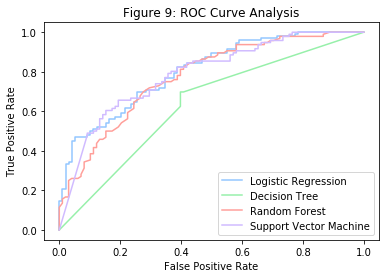

In [359]:
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_tree, tpr_tree, label="Decision Tree")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot(fpr_svc, tpr_svc, label="Support Vector Machine")
plt.legend()
plt.title('Figure 9: ROC Curve Analysis')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## SECTION 5: Deployment

The purpose of this section is to see how effective our model would be if we were to use it to place bets on the NCAA tournament. For each game we look up the money line odds for each team. We chose to use the money line because it only requires us to choose a team, unlike a point spread which would require us to determine how many points a team will win or lose by.

From the money line we have calculated the ratio of the bet that will be earned if we are correct. We will call this the winnings ratio. This is typically less than 1 for the favorite and more than 1 for the underdog. Below we have broken down the expected value in the 4 possible scenarios.

Correct bet: Win Bet Amount * winnings ratio

Incorrect bet: Lose Bet Amount

Correct no bet: 0

Incorrect no bet: 0

Expected Value of a bet = win_probability * Correct bet - Lose probability

This time I train the model on all of the data prior to the 2019 tournament and test using the 2019 tournament. Since we did not have an NCAA tournament this year this is the best simulation for a deployment of the model. I choose to bet on a team if it's expected value is above some threshold and it is greater than the value of choosing the other team.

In [348]:
# Function to calculate amount the model would have won in 2019
def calc_winnings(probabilities, lower_threshold, lower_win, lower_win_ratio, higher_win_ratio):
  BET_AMOUNT = 100
  # probability of higher ID team winning
  higher_prob = probabilities[:,0]
  # probability of lower ID team winning
  lower_prob = probabilities[:,1]
  # games the higher ID team won
  higher_win = -1 * (lower_win-1)

  # calculate expected value of bet on each team
  lower_expected_value = lower_prob * lower_win_ratio - higher_prob
  higher_expected_value = higher_prob * higher_win_ratio - lower_prob

  # pick team if expected value is above threshold and greater than picking the other team
  pick_lower = (lower_expected_value>higher_expected_value) & (lower_expected_value>lower_threshold)
  pick_higher = (higher_expected_value>lower_expected_value) & (higher_expected_value>lower_threshold)

  correct_lower = pick_lower * lower_win
  correct_higher = pick_higher * higher_win
  correct_picks = sum(correct_lower.astype(int)) + sum(correct_higher.astype(int))

  count_lower = sum(pick_lower.astype(int))
  count_higher = sum(pick_higher.astype(int))

  total_bets = count_lower + count_higher
  amount_at_risk = BET_AMOUNT * total_bets
  accuracy = correct_picks/total_bets

  winnings = sum(pick_lower.astype(int)* lower_win * (BET_AMOUNT*lower_win_ratio + BET_AMOUNT)) + sum(pick_higher.astype(int)* higher_win * (BET_AMOUNT * higher_win_ratio + BET_AMOUNT)) - amount_at_risk
  return winnings, amount_at_risk, accuracy

In [ ]:
%%capture
# Train on all data prior to 2019
# Normalize X prior to 2019
x_norm_prior = normalize(x_prior)

# Normalize 2019 data
x_norm_2019 = normalize(x_2019)

# Train model
log_model_prior = LogisticRegression()
log_model_prior.fit(x_norm_prior,y_prior)

# Get win probabilites for each team in 2019 tournament
logistic_probabilities_2019 = log_model_prior.predict_proba(x_norm_2019)

print("2019 Performance")
thresholds = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
for threshold in thresholds:
  winnings, amount_at_risk, accuracy = calc_winnings(logistic_probabilities_2019, threshold , y_2019['LowerWin'],df_2019['Lower Payout'], df_2019['Higher Payout'])
  print("\nLogistic Regression with Threshold " + str(threshold) + "\n"+str(winnings) + " won/lost on bets of " + str(amount_at_risk) + "\nROI = " + str(winnings/amount_at_risk))
  print("Pick Accuracy = " + str(accuracy));

2019 Performance

Logistic Regression with Threshold 0
-558.8030989238132 won/lost on bets of 5100

ROI = -0.10956923508310062

Pick Accuracy = 0.47058823529411764


Logistic Regression with Threshold 0.1
-592.9260532649823 won/lost on bets of 3300

ROI = -0.1796745615954492

Pick Accuracy = 0.36363636363636365


Logistic Regression with Threshold 0.2
71.1027237134349 won/lost on bets of 2500

ROI = 0.02844108948537396

Pick Accuracy = 0.44


Logistic Regression with Threshold 0.3
265.1395348837209 won/lost on bets of 2000

ROI = 0.13256976744186044

Pick Accuracy = 0.45


Logistic Regression with Threshold 0.4
-219.0 won/lost on bets of 1300

ROI = -0.16846153846153847

Pick Accuracy = 0.3076923076923077


Logistic Regression with Threshold 0.5
-237.0 won/lost on bets of 800

ROI = -0.29625

Pick Accuracy = 0.25


Logistic Regression with Threshold 0.6
-348.0 won/lost on bets of 600

ROI = -0.58

Pick Accuracy = 0.16666666666666666


Logistic Regression with Threshold 0.7
-500.0 won/lost on bets of 500

ROI = -1.0

Pick Accuracy = 0.0


Logistic Regression with Threshold 0.8
-300.0 won/lost on bets of 300

ROI = -1.0

Pick Accuracy = 0.0


Logistic Regression with Threshold 0.9
-200.0 won/lost on bets of 200

ROI = -1.0

Pick Accuracy = 0.0

## Section 6: Conclusion

Before pulling in rating information, we were able to achieve 63% accuracy with Logistic Regression (and close to this with other machine learning algorithms). We enhanced our model by pulling in Rating data from an outside source, and after pulling in rating information, we were able to achieve 72% accuracy with Logistic Regression. We tuned various models using GridSearch to optimize the model parameters to achieve this accuracy. We also calculated how much we could win by using this strategy. This requires a cost benefit analysis that takes into account the expected value of different outcomes. We found that our model could generate a return, but this is largely dependent on where we choose to set a threshold for expected value. The higher we set the expected value threshold the less diversified we become.

We spent an extensive amount of time on our modeling and on processing the data in a way that is effective. That said, if we were fleshing out the project further we would (1) spend more time figuring out how to deal with home-court advantage (which effects regular season games but is not easy to quantify in the tournament games), (2) incorporate player-level statistics in our model prediction (this would be a massive undertaking but would likely be insightful), (3) incorporate days off or rest in the model, (4) incorporate injuries in the model, and (5) incorporate coaches in the model (6) Manually add the money line for every year to find the best threshold location.

Clearly, there is an abundance of ways in which we could branch with this project. This paper showed us that it is possible to build an accurate model with time, hard work and patience.